# <b> Assignment 4

In this assignment, we will play with different clustering algorithms!

## <b> 0. Setup

In [ ]:
%%bash

# Run this cell every time you start working on the notebook
pip install --no-deps scprep
pip install --no-deps umap-learn
pip install phenograph
pip install --no-deps tasklogger
pip install graphtools

In [ ]:
# Run this cell every time you start working on the notebook
import pandas as pd
import numpy as np
import scprep, umap
import sklearn
import sklearn.cluster
import sklearn.manifold
import graphtools as gt
import phenograph
import matplotlib.pyplot as plt
import tasklogger

%matplotlib inline

## <b> 1. Preparatory steps (reusing parts of assignment 3)

In [ ]:
## TO DO
# Load saved data
# For this assignment, we're asking you to use the files data.pickle.gz
# and metadata.pickle.gz that the course staff generated for Assignment 3.

# This was based on our filtering steps.
# We set percentiles = (4 , 90) to filter for library sizes
# We set min_cells = 10 to filter lowly expressed genes
# Your files from assignment 3 may look a bit different from ours, based on how
# you did your filtering steps.

# PLEASE USE THE DATA WE HAVE GENERATED FOR THIS ASSIGNMENT. THIS IS TO ENSURE
# UNIFORMITY.

# You should see the files 'data.pickle.gz', 'metadata.pickle.gz'
# Add paths to these files in the functions below

data = pd.read_pickle('data.pickle.gz')
metadata = pd.read_pickle('metadata.pickle.gz')

In [ ]:
## TO DO
## Rerun PCA on the data.
# Hint: you already did this in homework 3, simply copy your code here

data_pca = scprep.reduce.pca(data, n_components=50, method='dense')

<Axes: title={'center': 'Sp1'}, xlabel='PC1', ylabel='PC2'>

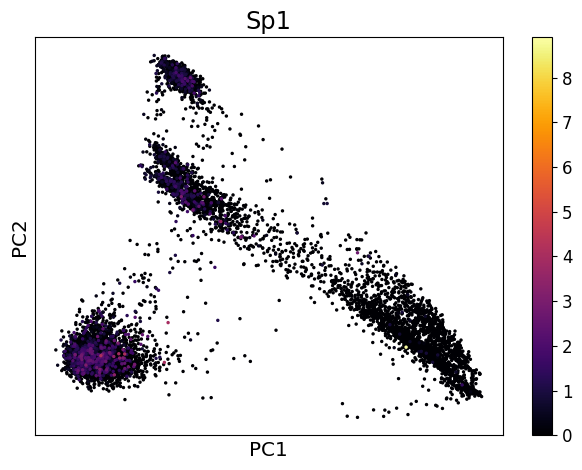

In [ ]:
## TO DO
## Plot PC1 and PC2 and color with expression for the gene 'SP1'
## Hint: We already did this for homework 3, simply copy your code here
## we have filled this in for you
expression = scprep.select.select_cols(data, exact_word='Sp1')

# we will sort cells by maximum expression so we can see where the gene is expressed
sort_index = expression.sort_values().index

scprep.plot.scatter2d(data_pca.loc[sort_index], c=expression.loc[sort_index], shuffle=False,
                      title='Sp1', ticks=None, label_prefix='PC')

## <b> 2. Clustering

The goal of clustering is to identify a partition of the data such that all of the observations within each partition (called a cluster) are more similar to each other than they are to those in other clusters. Many clustering algorithms exist, and they each have their own quirks (just like visualization algorithms). `sklearn` has implementations for some of the most popular ones and their [User Guide on Clustering](https://scikit-learn.org/stable/modules/clustering.html) is a good resource to understand general clustering approaches.

Here, we run a variety of clustering algorithms. We'll use `tasklogger` to measure how long each one takes.

<b> Note: </b>
Not all of these methods have been detailed in class. We will still look at the outputs from these methods in this assignment because they are interesting!  

### <b> Clustering single cell RNA-seq data

In [ ]:
# Phenograph is a super-sophisticate clusterer that automatically estimates
# how many clusters there are!

with tasklogger.log_task("phenograph"):
    phenograph_clusters, _, _ = phenograph.cluster(data_pca)

## TO DO ##
# how many seconds did phenograph take on this dataset ?
# e.g. 11.23 seconds
#
# your answer here: 8.32

Calculating phenograph...
Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.859750509262085 seconds
Jaccard graph constructed in 4.763725757598877 seconds
Wrote graph to binary file in 0.3117804527282715 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.895799
After 3 runs, maximum modularity is Q = 0.896837
Louvain completed 23 runs in 3.6945412158966064 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 9.79030728340149 seconds
Calculated phenograph in 9.79 seconds.


In [ ]:
## kmeans is one of the most common clustering algorithms,
## and we learned about this in lecture. The algorithm makes a lot of
## assumptions about our data (that may not be true!)

## TO DO ##
# Name an assumption we have to make about our data to run k-means
# your answer here: One assumption I believe we have to make is that there is variance in the data.The distribution of data points surrounding the centroid of a cluster should have similar distance from the center in a spherical orientation. We usually include this as a step in k-means clustering, repositioning the centroids.(Info from geeksforgeeks.com)

## TO DO ##
# pick a k for n_clusters (something between 2 and 30 is reasonable)
# you can change your answer based on the visualization excercise later

with tasklogger.log_task("KMeans"):
    kmeans_clusters = sklearn.cluster.KMeans(n_clusters = 14).fit_predict(data_pca)

# You may see a warning when you run this cell -
# 'FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4.
# Set the value of `n_init` explicitly to suppress the warning'
# Please feel free to ignore the warning!

## TO DO ##
# how many seconds did kmeans take on this dataset?
#
# your answer here: 0.20 seconds

Calculating KMeans...
Calculated KMeans in 0.14 seconds.


In [ ]:
import graphtools as gt
G = gt.Graph(data_pca)
G_igraph = G.to_igraph()

## spectral clustering uses a laplacian graph representation to estimate clusters
## it's more flexible than kmeans but comes with its own possibly false assumptions

## TO DO ##
# similarly, pick a number for n_clusters for spectral clustering

with tasklogger.log_task("Spectral clustering"):
    spec_op = sklearn.cluster.SpectralClustering(n_clusters = 20, affinity='precomputed')
    spectral_clusters = spec_op.fit_predict(G.K)

## TO DO ##
# how many seconds did spectral clustering take on this dataset ?
#
# your answer here: 6.44 seconds

Calculating Spectral clustering...
Calculated Spectral clustering in 7.54 seconds.


So far, we've looked at three popular algorithms for clustering: KMeans, Spectral Clustering, and Phenograph ("Louvain method").

By default, cluster numbers are meaningless. This makes it difficult to compare clusterings, because cluster "0" can refer to entirely different cells between runs of the same algorithm.

To enforce some consistency, we are going to reorder the clusters so that cluster "0" is always on the far right of the PCA plot, and the highest-numbered cluster is always on the far left.

In [ ]:
clusterings = {'Phenograph':phenograph_clusters,
               'KMeans':kmeans_clusters,
               'Spectral':spectral_clusters}

for alg in clusterings:
    cl_nu = scprep.utils.sort_clusters_by_values(clusterings[alg], -data_pca.iloc[:,0])
    clusterings[alg] = cl_nu

Now we will visualize the clusters (we also label the number of clusters for each method at the top of the plot)

<b> NOTE: </b> Phenograph's choice of n_clusters is CONTEXT SPECIFIC -- it is not necessarily a good choice when using a different algorithm

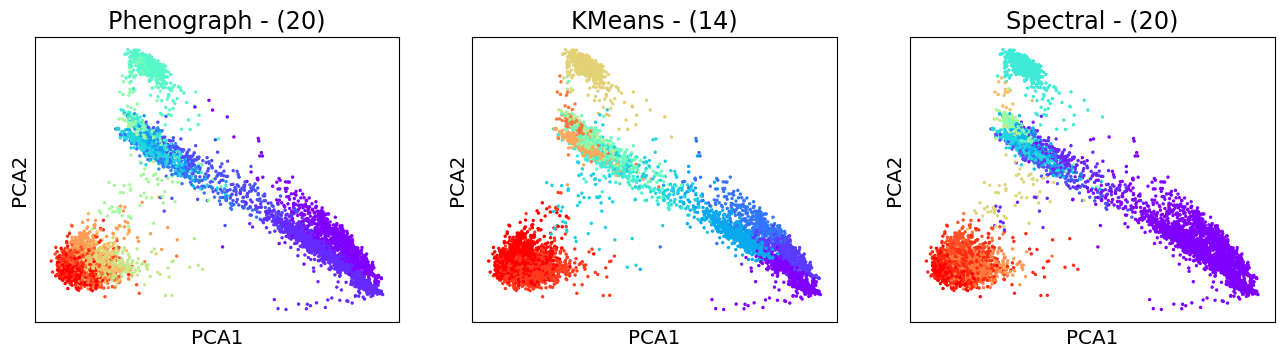

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(16,16), subplot_kw={'aspect':'equal'})

for ax, algorithm in zip(axes.flatten(), clusterings):
  scprep.plot.scatter2d(data_pca, c=clusterings[algorithm], cmap=plt.cm.rainbow,
                        title='{} - ({})'.format(algorithm, len(np.unique(clusterings[algorithm]))),
                        ticks=False, label_prefix="PCA", legend=False, discrete=True,
                        ax=ax)

### <b> Choosing n_clusters rationally

It's pretty difficult to know a priori exactly how many clusters a dataset has (especially on complex data!). One way is to choose a 'metric' that evaluates how 'good' a clustering is.

We will be using Prediction Strength [1] here, which will hopefully help us quantitatively gauge how many clusters we should choose, and we will only do so for kmeans (due to speed).

[1] See Tibshirani and Walther (2005) for more on prediction strength. https://gwalther.su.domains/predictionstrength.pdf

In [ ]:
from sklearn.model_selection import train_test_split
from itertools import combinations
from scipy import sparse

def get_comemberships(dat, n_clusters, model, kwargs={}):
  ## helper function
  # returns comembership matrix and model
  model = model(n_clusters=n_clusters, **kwargs)
  model.fit(dat)

  labels = model.predict(dat)
  comember = labels_to_mat(labels, n_clusters, N=dat.shape[0])

  return comember, model

def labels_to_mat(labels, n_clusters, N):
  ## helper function
  # comembership matrix helper

  # create and fill an NxN co-membership matrix
  comember = np.zeros((N, N), dtype=bool)
  for i in range(n_clusters):
    match_idx = np.where(labels==i)[0]

    # slow, memory safe (we will symmetrize + add diagonal after)
    match_idx = iter(combinations(match_idx, 2))
    for (j,k) in match_idx:
      comember[j,k] = True

  # transpose here is memory bottleneck
  comember = np.maximum(comember, comember.transpose())
  comember[np.diag_indices_from(comember)] = True

  # sparsify output for storage space
  comember = sparse.csr_matrix(comember)
  return comember

def prediction_strength(full_dat, n_clusters, n_CV=3,
                        verbose=False, model=sklearn.cluster.KMeans,
                        kwargs={}):
  test_size = 1./n_CV
  res = []
  for i in range(n_CV):
    train_dat, test_dat = train_test_split(full_dat, test_size=test_size)
    N_test = test_dat.shape[0]
    __, train_model  = get_comemberships(train_dat, n_clusters, model=model, kwargs=kwargs)
    ground_truth, __ = get_comemberships(test_dat, n_clusters, model=model, kwargs=kwargs)

    pred_labels      = labels_to_mat(train_model.predict(test_dat), n_clusters, N_test)

    # when match_count is N_test**2, there is no error
    match_count      = ground_truth.minimum(pred_labels).sum()
    res.append(match_count/(N_test**2))

  if verbose:
    print(res)

  return np.mean(res)

In [ ]:
## TO DO
## Note: this might take a while to run depending on your 'end' value!
# It took me ~20 minutes to get one run done.
# Your runtime could vary depending upon what your end value is,
# how busy the server is etc.

# We will calculate the prediction strengths at each choice of n_clusters between
# start and end.

start = 2
end   = 8

pred_strengths = []
for i in range(start, end):
  pred_strengths.append(prediction_strength(full_dat=data,
                                            n_clusters=i, n_CV=3,
                        verbose=False, model=sklearn.cluster.KMeans,
                        kwargs={}))

# This cell might trigger a warning.
# FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4.
# Set the value of `n_init` explicitly to suppress the warning
# You can ignore this warning! Your code will still run.

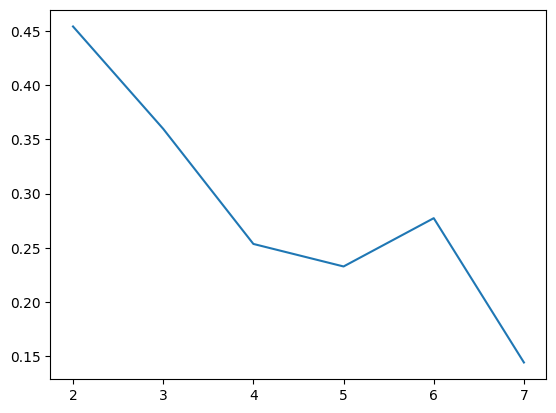

In [ ]:
# we will now plot pred_strengths for our choices of n_clusters
n_clusters = list(range(2, end))
plt.plot(n_clusters, pred_strengths)
plt.show()

Now that you've generated a curve for prediction strength, let's interpret our results and pick a value for n_clusters.

A higher prediction strength (closer to 1) is ideal. However, a single cluster (i.e. n_clusters=1) will always have a 1.0 prediction strength (by definition, see [1] above), and similarly, lower numbers of n_clusters will have *higher strengths* because there is less opportunity for mismatches.

We're looking to pick a relatively "high" strength for a relatively "decent-sized" n_clusters

There is no right answer for choosing n_clusters.There are reasonable choices and those that aren't as reasonable. Furthermore, there could be ambiguity in what your choice should be. Try and pick a value of n_clusters that seems reasonable to you.

The curve might be "noisy" but should start high and gradually decrease over time.

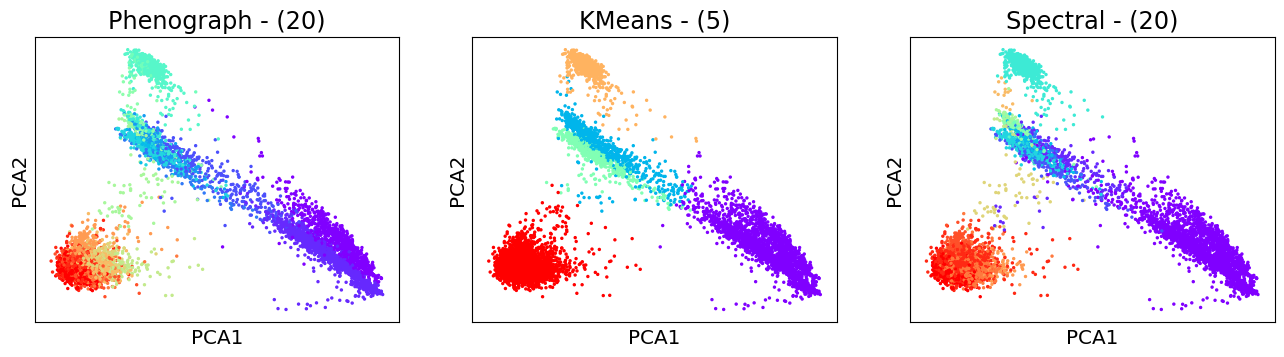

In [ ]:
## TO DO

optimal_n_clusters = 5

# This cell might trigger a warning.
# FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4.
# Set the value of `n_init` explicitly to suppress the warning
# You can ignore this warning! Your code will still run.

kmeans_clusters = sklearn.cluster.KMeans(n_clusters=optimal_n_clusters).fit_predict(data_pca)

clusterings['KMeans'] = kmeans_clusters


## revisualize your clusterings for KMeans vs others

for alg in clusterings:
    cl_nu = scprep.utils.sort_clusters_by_values(clusterings[alg], -data_pca.iloc[:,0])
    clusterings[alg] = cl_nu

fig, axes = plt.subplots(1,3, figsize=(16,16), subplot_kw={'aspect':'equal'})

for ax, algorithm in zip(axes.flatten(), clusterings):
  scprep.plot.scatter2d(data_pca, c=clusterings[algorithm], cmap=plt.cm.rainbow,
                        title='{} - ({})'.format(algorithm, len(np.unique(clusterings[algorithm]))),
                        ticks=False, label_prefix="PCA", legend=False, discrete=True,
                        ax=ax)

## TO DO ##
# in 2-3 sentences, does your choice of n_clusters seem right for kmeans?
# i.e. does it LOOK like a "decent" choice of clusters?
# Answer: Testing different numbers here helped me to decide whether the cluster choice seemed decent for kmeans.
#My goal mainly was to obtain distinct seperation between the variants in the graphs, using the Spectral and Phenograph generated plots as my sort of Ground Truth. I also know that a lower cluster count closer to 1 is somewhat reasonable from our directions above. 5 clusters highlights the distnict regions I see in the other plots and I think they're decent.

### <b> Comparing clustering methods quantitatively

We can use a metric, called the adjusted rand score, to quantify how similar any given pair of clustering results are. This is a similarity metric, so two identical clusterings will produce a score of `1.0`. If every point is randomly assigned to different clusters, then the adjusted rand score will be close to `0.0`. You can learn more about this metric in the `sklearn` user guide: https://scikit-learn.org/stable/modules/clustering.html#adjusted-rand-score.

In [ ]:
all_clusterings = []
all_algorithms = list(clusterings.keys())
for algo in all_algorithms:
    all_clusterings.append(clusterings[algo])
all_clusterings = np.vstack(all_clusterings)

Here, we're using `pdist` with a custom distance metric. Note, `sklearn.metrics.adjusted_rand_score` is actually a similarity metric, not a distance metric. So this code is not good practice and qualifies as a hack. That being said, it works.

In [ ]:
from scipy.spatial.distance import pdist, squareform
cluster_similarities = squareform(pdist(all_clusterings, metric=sklearn.metrics.adjusted_rand_score))
# squareform assumes diagonals will be 0, but they're actually 1 because this is a similarity metric
# so we need to add 1's on the diagonal with np.eye()
cluster_similarities = cluster_similarities + np.eye(3)

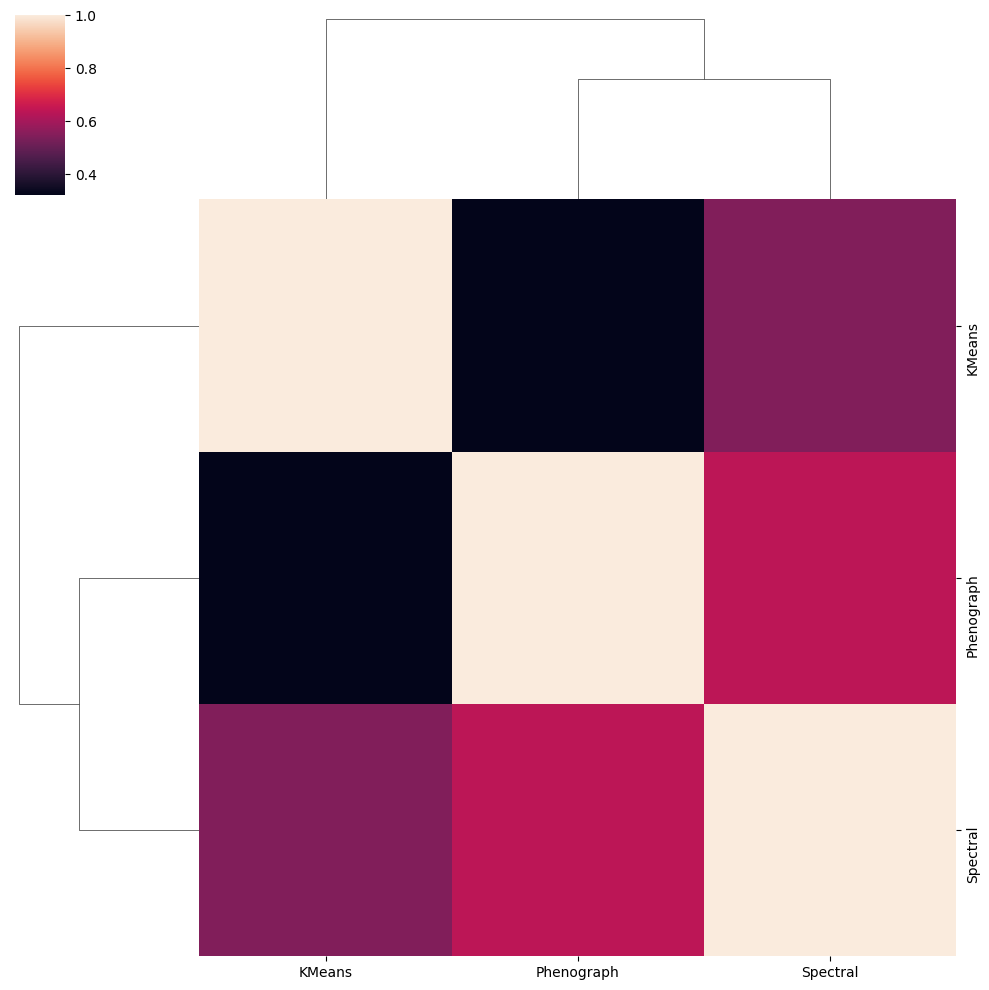

In [ ]:
import seaborn as sns
sns.clustermap(cluster_similarities, xticklabels=all_algorithms, yticklabels=all_algorithms)
plt.show()

In [ ]:
# TODO:
# Which clustering results are the most similar?
# Answer here: If a square is lighter that means it has lower degree of difference, so we see that Phenograph and Kmeans share a black square almost always, meaning they're similar.

# Which clustering results are the most different?
# Answer here:If a square is darker that means it has HIGHER degree of difference, so we see that Phenograph and Spectral share a pink square almost always, meaning they're similar.

## <b> 3. Analysis

### <b> Looking at the expression of interesting genes

<b> Gene list:

* Trf
* Mbp
* Ly6c1
* Clu
* Dcn
* Cspg5
* Acta2
* Meg3
* Kctd13

In [ ]:
## TO DO ##

# Make a list of genes
# check the capitalization of your gene names!

gene_list = ["Trf","Mbp","Ly6c1","Clu","Dcn","Cspg5","Acta2","Meg3","Kctd13"]

# Let's look at the dataframe 'data', subsetted to just the genes we've listed above
data[gene_list]

,Trf,Mbp,Ly6c1,Clu,Dcn,Cspg5,Acta2,Meg3,Kctd13
O5.MAA000570.3_8_M.1.1_myeloid,7.679528,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C3.MAA000570.3_8_M.1.1_myeloid,2.327267,0.0,0.0,0.0,0.113424,0.0,0.0,0.0,0.0
F17.MAA000570.3_8_M.1.1_myeloid,0.0,0.0,0.0,0.134424,0.134424,0.0,0.0,0.0,0.0
I17.MAA000570.3_8_M.1.1_myeloid,5.973609,1.66163,0.0,0.0,0.167,0.0,0.0,0.0,0.0
K17.MAA000570.3_8_M.1.1_myeloid,3.906222,0.0,0.0,0.0,0.144477,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
P2.B003728.3_56_F.1.1_non-myeloid,0.0,21.141832,0.0,0.650903,1.301806,0.0,0.0,0.0,0.0
P4.B003728.3_56_F.1.1_non-myeloid,1.626777,11.954319,0.614864,6.679131,0.614864,0.0,0.0,0.0,0.0
P5.B003728.3_56_F.1.1_non-myeloid,0.0,29.40121,0.870026,1.506929,1.230402,0.0,0.0,0.0,0.0
P6.B003728.3_56_F.1.1_non-myeloid,0.870982,18.352737,0.0,0.0,0.870982,0.0,0.0,0.0,0.0


<b> TODO: </b>

Plot the expression of each of these genes on your low-dimension PCA plot. Do each gene individually so that you have 9 small plots to take up less space, perhaps arranged in a 3x3 grid.

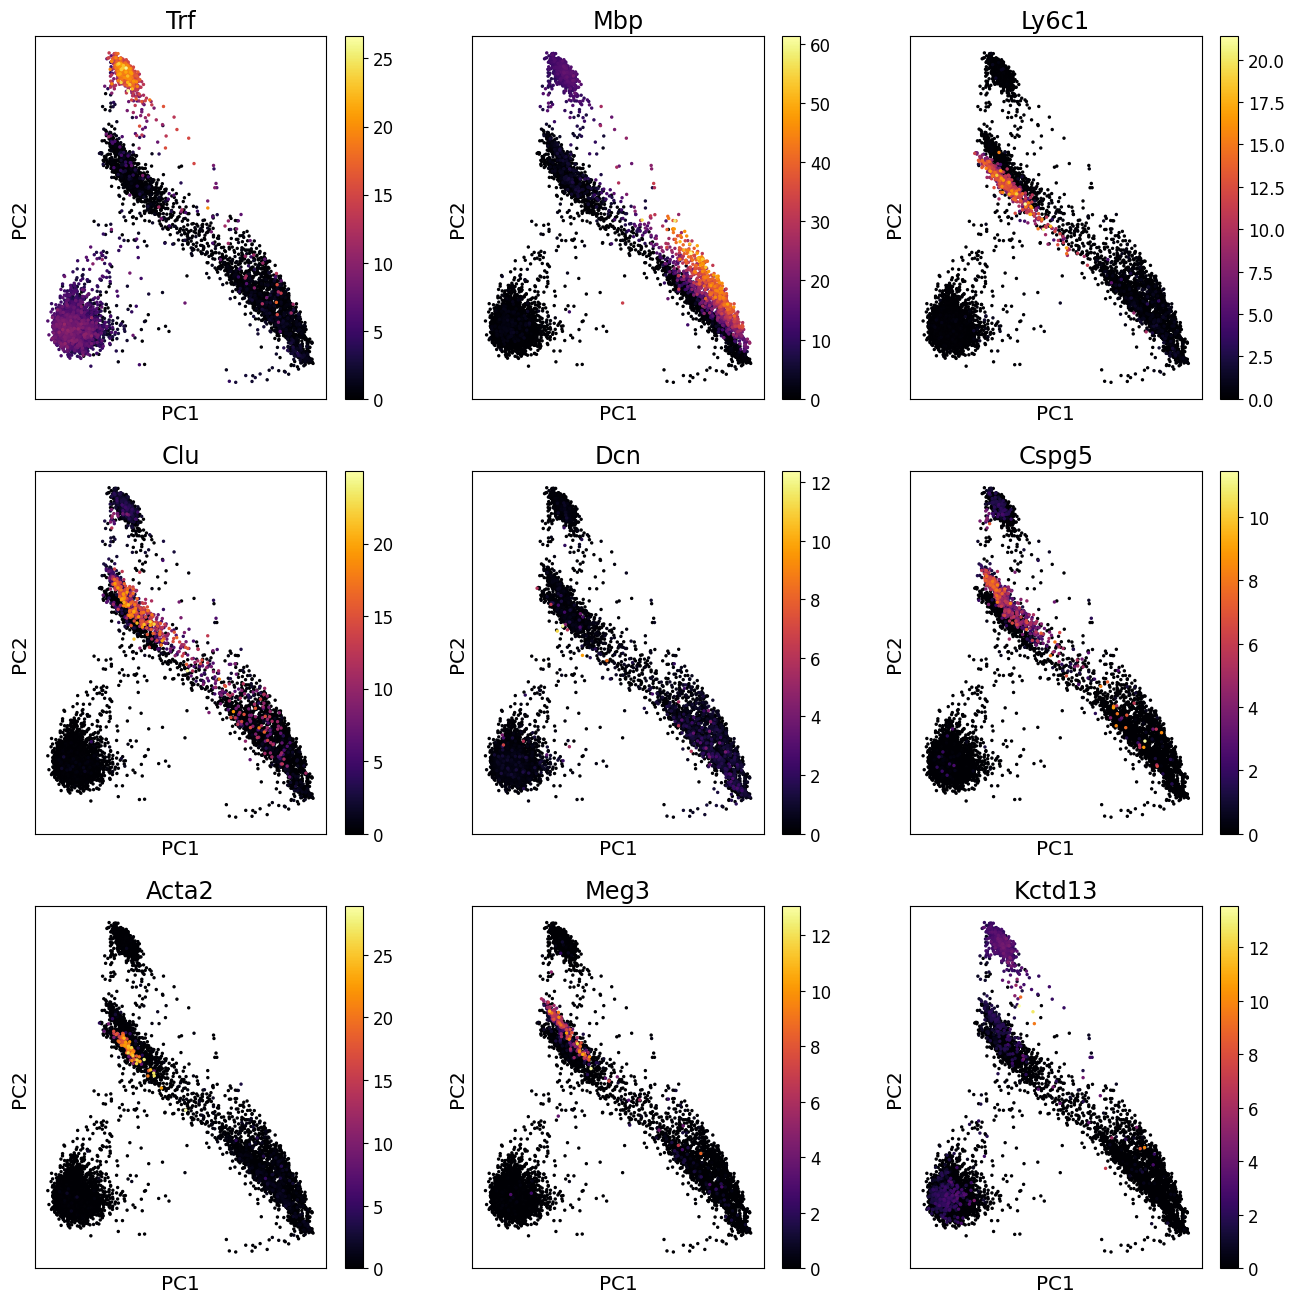

In [ ]:
# We did something very similar in Assignment 3.
# You can use code from the previous assignment for this

fig, axes = plt.subplots(3,3, figsize=(16,16))

for gene, ax in zip(gene_list, axes.flatten()):
  ## TO DO ##
  expression = scprep.select.select_cols(data, exact_word = gene)

  # we will sort cells by maximum expression so we can see where the gene is expressed
  sort_index = expression.sort_values().index

  scprep.plot.scatter2d(data_pca.loc[sort_index], c=expression.loc[sort_index], shuffle=False,
                       title=gene, ticks=None, label_prefix='PC', ax= ax)

### <b> Jitterplot

The goal of a jitterplot plot is to examine the distribution of values associated with each cell in a set of clusters.

Each point is a cell and the x-axis represents the cluster assignment of that cell. There's a little bit of noise added to the x-position of the cell (that's the jitter). The y-axis represents expression of a given gene.

You can change which gene is plotted by changing the `curr_gene` variable. All of the genes in the mentioned gene-list should work okay.

In [ ]:
# ==============
# choose your favorite clustering method from: Phenograph, KMeans, and Spectral

## TO DO -- analyze a clustering of your choice (pick whichever is your favorite!)

clusters = clusterings['Spectral']
# ==============

<Axes: title={'center': 'Mbp'}, ylabel='Mbp'>

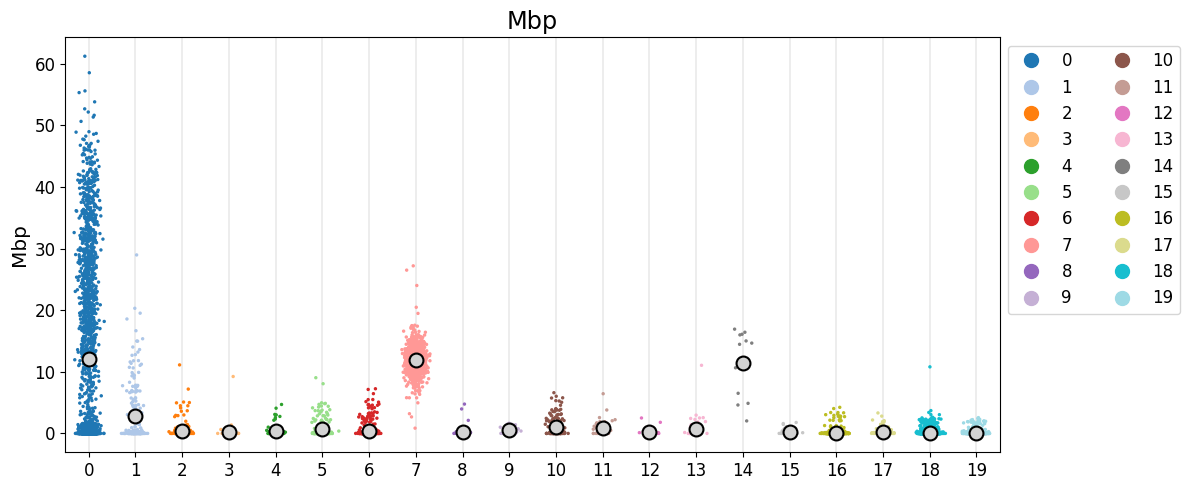

In [ ]:
## TO DO ##
## select an interesting gene from the gene list in section '3. Analysis'

# curr_gene = fill-gene-name-here
curr_expression = scprep.select.select_cols(data, exact_word='Mbp')
scprep.plot.jitter(clusters, curr_expression, c=clusters, figsize=(12, 5),
                   legend_anchor=(1,1), title='Mbp')

<Axes: title={'center': 'Clu'}, ylabel='Clu'>

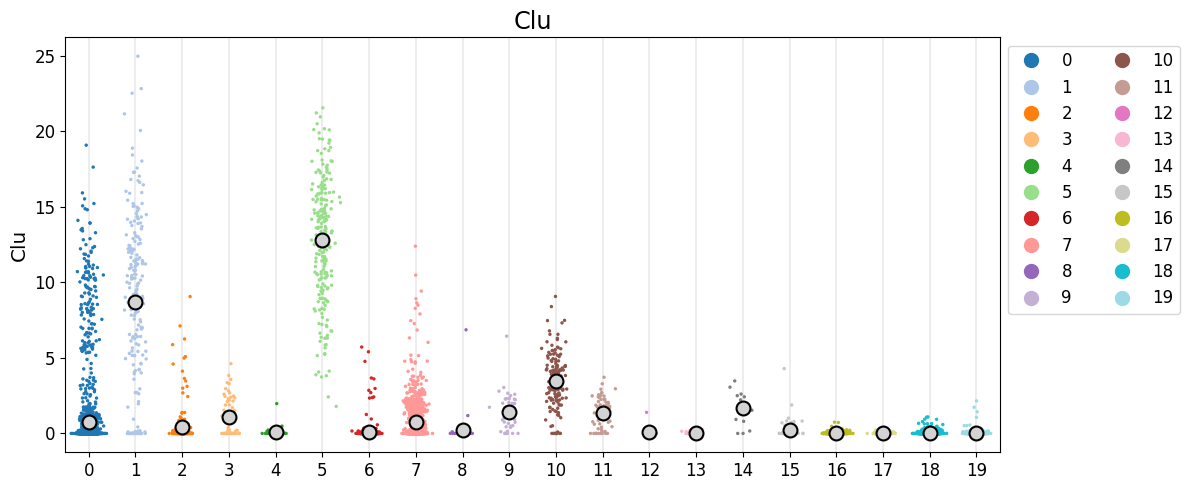

In [ ]:
## TO DO ##
## select another gene from the gene list in section '3. Analysis'

# curr_gene = fill-gene-name-here
curr_expression = scprep.select.select_cols(data, exact_word='Clu')
scprep.plot.jitter(clusters, curr_expression, c=clusters, figsize=(12, 5),
                   legend_anchor=(1,1), title='Clu')

### <b> Research

In [ ]:
print(len(data), len(metadata['FACS.selection']))

9081 9081


In [ ]:
print(metadata.head())

                                plate.barcode mouse.id         tissue  \
O5.MAA000570.3_8_M.1.1_myeloid      MAA000570    3_8_M  Brain_Myeloid   
C3.MAA000570.3_8_M.1.1_myeloid      MAA000570    3_8_M  Brain_Myeloid   
F17.MAA000570.3_8_M.1.1_myeloid     MAA000570    3_8_M  Brain_Myeloid   
I17.MAA000570.3_8_M.1.1_myeloid     MAA000570    3_8_M  Brain_Myeloid   
K17.MAA000570.3_8_M.1.1_myeloid     MAA000570    3_8_M  Brain_Myeloid   

                                  subtissue FACS.selection mouse.sex  \
O5.MAA000570.3_8_M.1.1_myeloid   Cerebellum      Microglia         M   
C3.MAA000570.3_8_M.1.1_myeloid   Cerebellum      Microglia         M   
F17.MAA000570.3_8_M.1.1_myeloid  Cerebellum      Microglia         M   
I17.MAA000570.3_8_M.1.1_myeloid  Cerebellum      Microglia         M   
K17.MAA000570.3_8_M.1.1_myeloid  Cerebellum      Microglia         M   

                                 library_size  
O5.MAA000570.3_8_M.1.1_myeloid       732851.0  
C3.MAA000570.3_8_M.1.1_myeloid  

In [ ]:
print(metadata['FACS.selection'].unique())

['Microglia' 'Neurons' nan 'Multiple']


In [ ]:
print(data_pca[:5])

                                       PC1        PC2       PC3        PC4  \
O5.MAA000570.3_8_M.1.1_myeloid  -31.205625 -13.492897  0.544978   8.137132   
C3.MAA000570.3_8_M.1.1_myeloid  -26.348017 -13.554137 -0.511998   8.328714   
F17.MAA000570.3_8_M.1.1_myeloid -23.903751 -18.483189 -0.972480   5.721053   
I17.MAA000570.3_8_M.1.1_myeloid -26.685665 -12.031000 -0.972719  10.280089   
K17.MAA000570.3_8_M.1.1_myeloid -17.117643 -17.986101  1.581938   2.742021   

                                       PC5       PC6       PC7       PC8  \
O5.MAA000570.3_8_M.1.1_myeloid   11.029279 -0.319421 -0.061529 -2.480142   
C3.MAA000570.3_8_M.1.1_myeloid    8.029261 -1.457935 -0.834257 -2.864278   
F17.MAA000570.3_8_M.1.1_myeloid   7.658926 -1.165141 -0.548799 -4.370887   
I17.MAA000570.3_8_M.1.1_myeloid  11.648723 -0.651531 -1.547400 -2.243108   
K17.MAA000570.3_8_M.1.1_myeloid   4.779085 -1.621682  0.152485 -5.851076   

                                      PC9      PC10  ...      PC41      PC

In [ ]:
metadata['FACS.selection'] = (
    metadata['FACS.selection']
    .astype(str)
    .replace('nan','Unknown')
)


<Axes: title={'center': 'Spectral - (4)'}, xlabel='PCA1', ylabel='PCA2'>

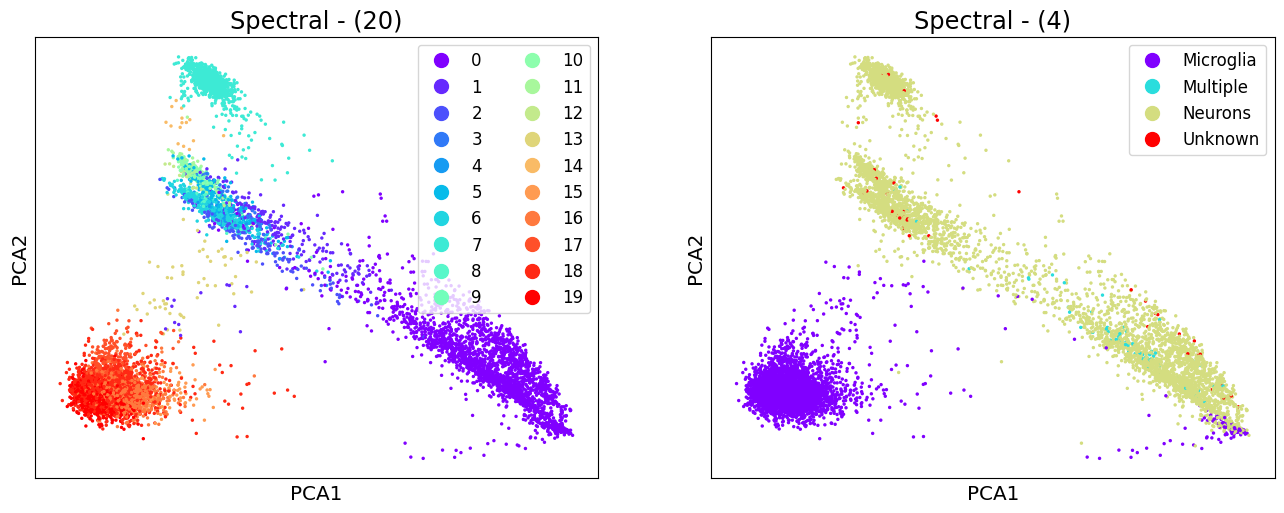

In [ ]:
# We will look at the low dimensional representation of our cells, coloured both by cluster number and their
# FACS label

fig, axes = plt.subplots(1,2, figsize=(16,16), subplot_kw={'aspect':'equal'})

# TODO:
scprep.plot.scatter2d(data_pca, c=clusters, cmap=plt.cm.rainbow,
                        # TO DO -- write the name of your algorithm
                      title='{} - ({})'.format('Spectral', len(np.unique(clusters))),
                      ticks=False, label_prefix="PCA", legend=True, discrete=True,
                      ax=axes[0])

## TO DO -- set c so that you can color by cell types ('FACS.selection') instead of the clusters
# Hint: What dataframe has your metadata?
# How can you access the 'FACS.selection' column of the metadata dataframe?

scprep.plot.scatter2d(data_pca, c=metadata['FACS.selection'], cmap=plt.cm.rainbow,
                        # TO DO -- write the name of your algorithm
                      title='{} - ({})'.format('Spectral', len(np.unique(metadata['FACS.selection']))),
                      ticks=False, label_prefix="PCA", legend=True, discrete=True,
                      ax=axes[1])

<Axes: title={'center': 'Cspg5'}, ylabel='Cspg5'>

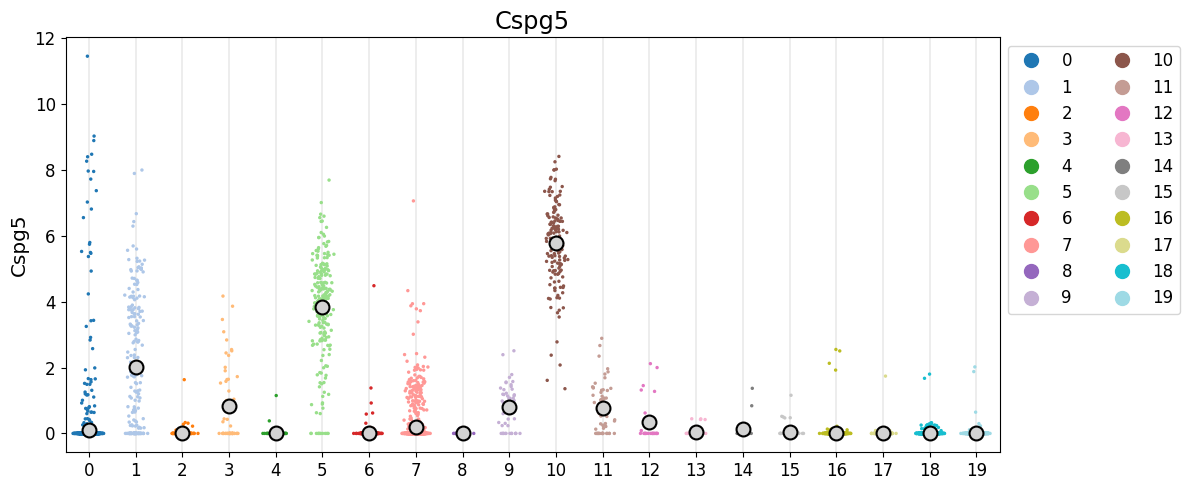

In [ ]:
## TODO ##
## select a gene from the gene list in section '3. Analysis' so you can answer the questions in the cell below this cell.
# Feel free to play around with the genes we've listed to hone in on a gene.
# Some trial and error is completely ok!

curr_gene = 'Cspg5'
curr_expression = scprep.select.select_cols(data, exact_word=curr_gene)
scprep.plot.jitter(clusters, curr_expression, c=clusters, figsize=(12, 5),
                   legend_anchor=(1,1), title=curr_gene)

In [ ]:
## TO DO ##

# What is your chosen gene? Cspg5

# Google and tell us cell types express this gene
#This Gene usually expresses neurons.

# What is(are) the cluster label(s) of the cluster(s) that express this gene? The cluster labels seem to be highly expressed in in 10 and 5, which are differnt colors in each plot display.

# What are the FACS.selection labels for the clusters that express this gene? I believe they are also teal in the PCA plot and light chartreuses green in the FACS plot, which are designated as neurons.
# Does it match what you've seen found on googling this gene? Yes all of this information supports the internet search I made, meaning that this Gene is mostly expressed in neurons.


## NOTE: You can try running the section on differential expression (see below) to check
# whether your gene expression is statistically different in the cluster label
# than in the original dataset (not needed for submission)

### <b> Differential expression </b>

In the above exercise, we manually inspected known marker genes to annotate clusters. Here, we're going to simply identify the genes that change the most between two groups.

You can easily calculate basic differential expression statistics using `scprep.stats.differential_expression` and `scprep.stats.differential_expression_by_cluster`. More details about these methods can be found in the [documentation](https://scprep.readthedocs.io/en/stable/reference.html#scprep.stats.differential_expression).

In [ ]:
data_sparse = scprep.utils.SparseDataFrame(data)

In [ ]:
## TO DO ##
## pick a cluster to test
# This might take a couple of minutes to run!

curr_cluster = 14
ttest_results = scprep.stats.differential_expression(data_sparse[clusters == curr_cluster],
                                                         data_sparse[clusters != curr_cluster],
                                                         measure='ttest')

In [ ]:
top_genes = ttest_results['ttest'].abs().sort_values(ascending=False)[:50]

#### <b> Print the 20 most differentially expressed genes

In [ ]:
top_genes.head(n=40)

,ttest
Sepp1,108.140738
C1qa,88.338915
C1qb,84.819254
Cyba,84.369742
Ctss,84.015999
Itgb5,83.484003
C1qc,83.342488
Tmem119,83.165049
Fcer1g,82.852674
F11r,82.590390


## TODO
Once you are done, please submit your notebook and a PDF copy to Gradescope! Zip these files together, but do not include any of the data files.